# Metodologia Box-Jenkins com BoxJenkinsPandas

## 1. Introdução

O objetivo deste notebook é demonstrar a aplicação prática da Metodologia Box-Jenkins para modelagem de séries temporais. Utilizaremos uma biblioteca customizada (BoxJenkinsPandas) para realizar as quatro etapas fundamentais do processo:

1. Identificação
2. Estimação
3. Diagnóstico
4. Previsão

### Dados

Utilizaremos a base de dados de Consumo de Cerveja [aqui](https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting?select=BeerWineLiquor.csv). A série original possui tendência e sazonalidade. Para simplificar e focar na metodologia ARIMA (não sazonal), assumiremos que estamos modelando a série já tratada ou focaremos na captura da dinâmica de curto prazo.

In [1]:
# Configuração inicial para exibir gráficos no Notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from boxjenkins import BoxJenkinsPandas # Sua lib customizada

# Configuração de estilo
plt.style.use('ggplot')

## 2. Carregamento e Preparação dos Dados

Carregamos a série temporal. A metodologia exige que os dados sejam uma sequência de observações ordenadas no tempo.

Arquivo não encontrado. Gerando dados sintéticos similares para demonstração...


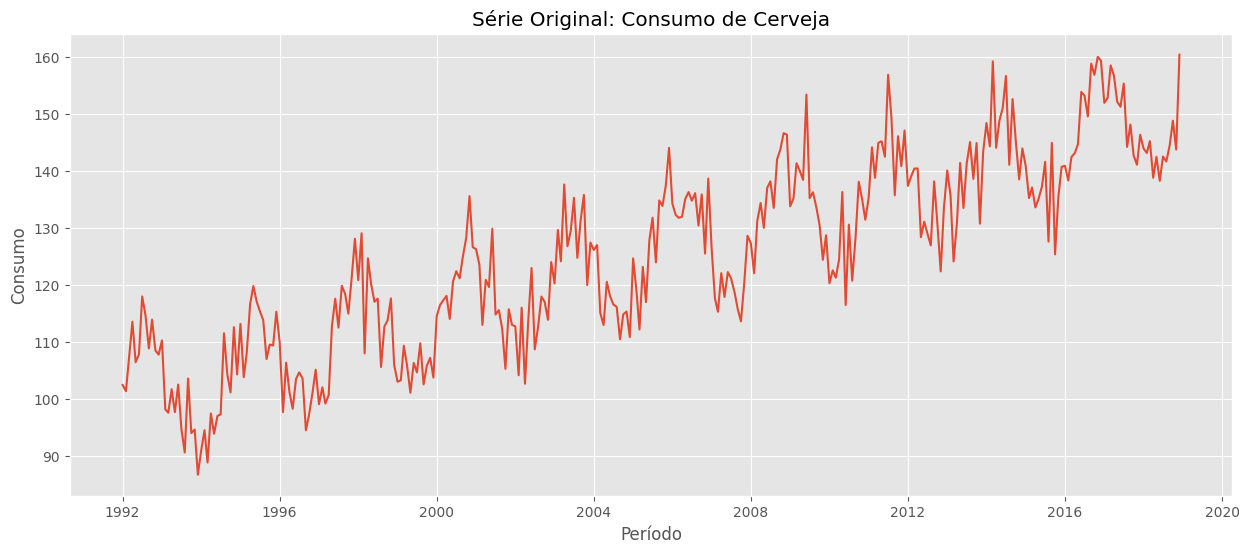

In [ ]:
# Carregar dados (Exemplo baseado no dataset Beer.csv)
# Criar dummy similar para teste

print("Gerando dados sintéticos similares para demonstração...")
import numpy as np

dates = pd.date_range(start="1992-01-01", periods=324, freq="MS")
# Simula tendência + sazonalidade + ruído (ARIMA)
np.random.seed(42)
trend = np.linspace(100, 150, 324)
seasonal = 10 * np.sin(np.linspace(0, 20 * np.pi, 324))
noise = np.random.normal(0, 5, 324)
data = trend + seasonal + noise
df = pd.DataFrame({"valor": data}, index=dates)
series = df["valor"]

# Visualização da série original
plt.figure(figsize=(15, 6))
plt.plot(series)
plt.title("Série Original: Consumo de Cerveja")
plt.xlabel("Período")
plt.ylabel("Consumo")
plt.show()

## 3. Instanciação do Modelo

Criamos o objeto da nossa biblioteca. Diferente de bibliotecas prontas que exigem definir p,d,q imediatamente, a metodologia Box-Jenkins começa com a análise dos dados.

In [3]:
# Instanciando a classe com os dados e frequencia
model = BoxJenkinsPandas(
    data=series.tolist(),
    dates=series.index,
    freq="MS",  # Mensal
    run_name="analise_cerveja",
    show_plots=True,  # Para exibir no notebook
)

📁 Execução iniciada: runs/analise_cerveja


## 4. Fase 1: Identificação

O objetivo desta fase é determinar a ordem de diferenciação (d) necessária para tornar a série estacionária e identificar as ordens prováveis do processo Auto-Regressivo (p) e de Médias Móveis (q).

### Conceito:

**Estacionariedade (d)**: Uma série é estacionária se sua média e variância são constantes. Se a Função de Autocorrelação (FAC) decai muito lentamente, a série não é estacionária e precisa de diferenciação.

**Escolha de p e q**:
  *  **ACF (FAC)**: Indica a ordem q (Médias Móveis). Se houver um corte após o lag q, sugere um MA(q).
  *  **PACF (FACP)**: Indica a ordem p (Auto-Regressivo). Se houver um corte após o lag p, sugere um AR(p).

Analisando d=0...
📊 Gráfico salvo: runs/analise_cerveja/plots/01_identificacao_d0.png


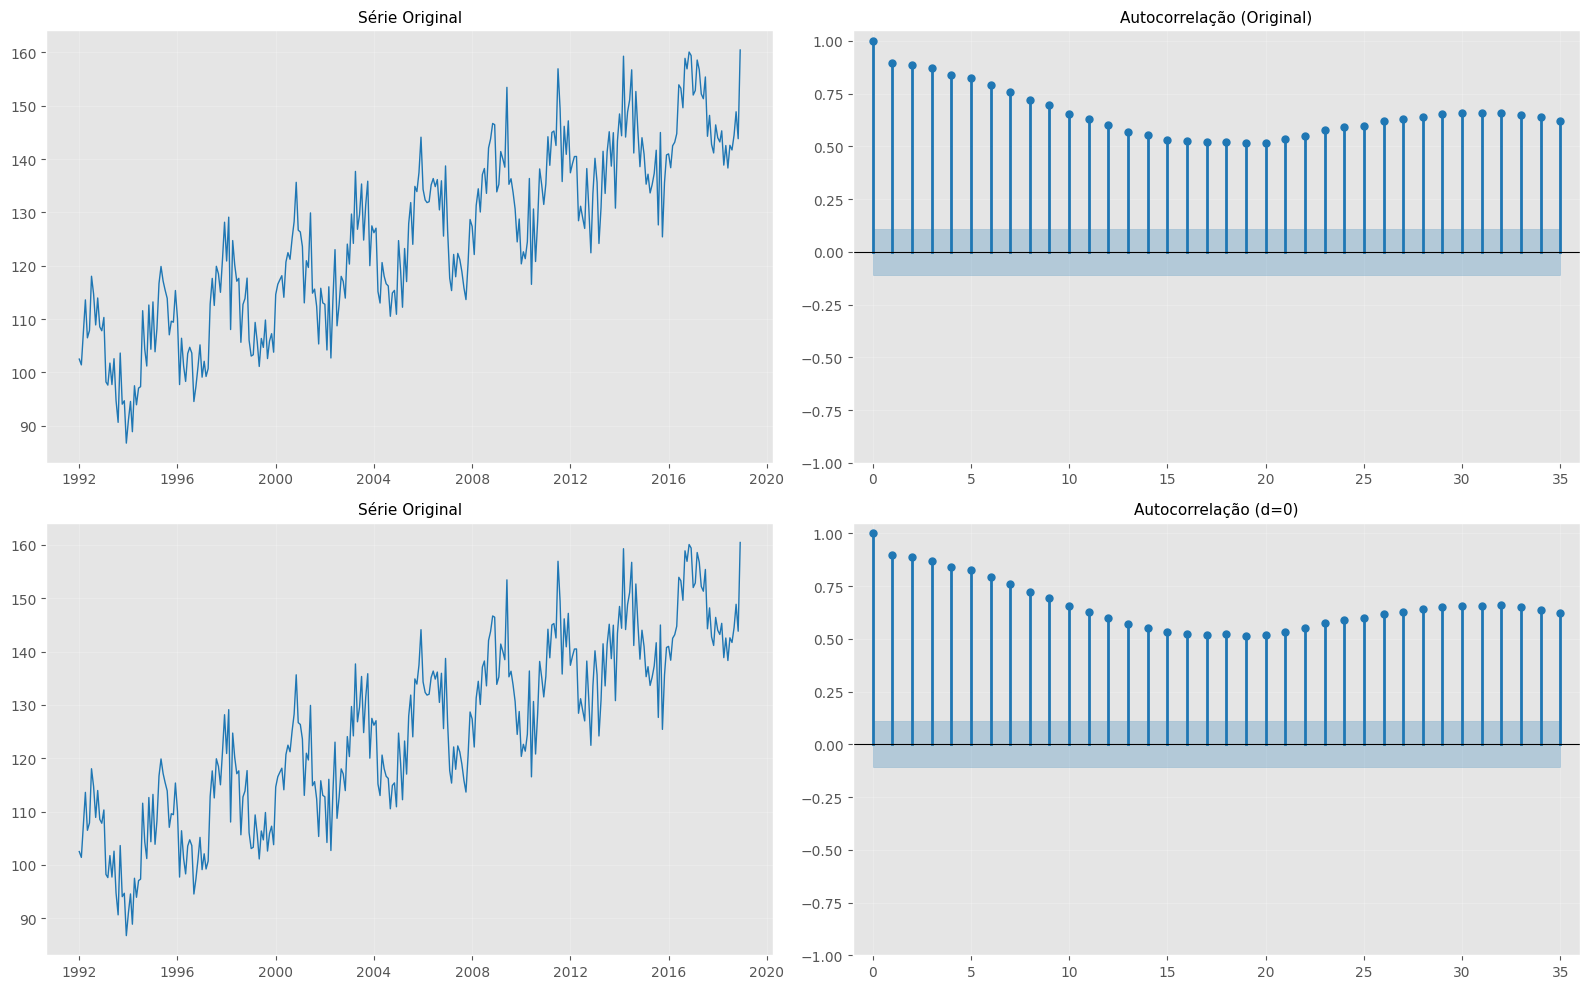

Identificação (d=0): Observe o decaimento para escolher p e q.


In [4]:
# Tenta d=0 (Série Original)
print("Analisando d=0...")
model.identificacao(d=0)

*Análise*: Se a FAC decair lentamente (como visto nos dados de cerveja originais), indica não estacionariedade. Aplicamos então a diferenciação.

Analisando d=1...
📊 Gráfico salvo: runs/analise_cerveja/plots/01_identificacao_d1.png


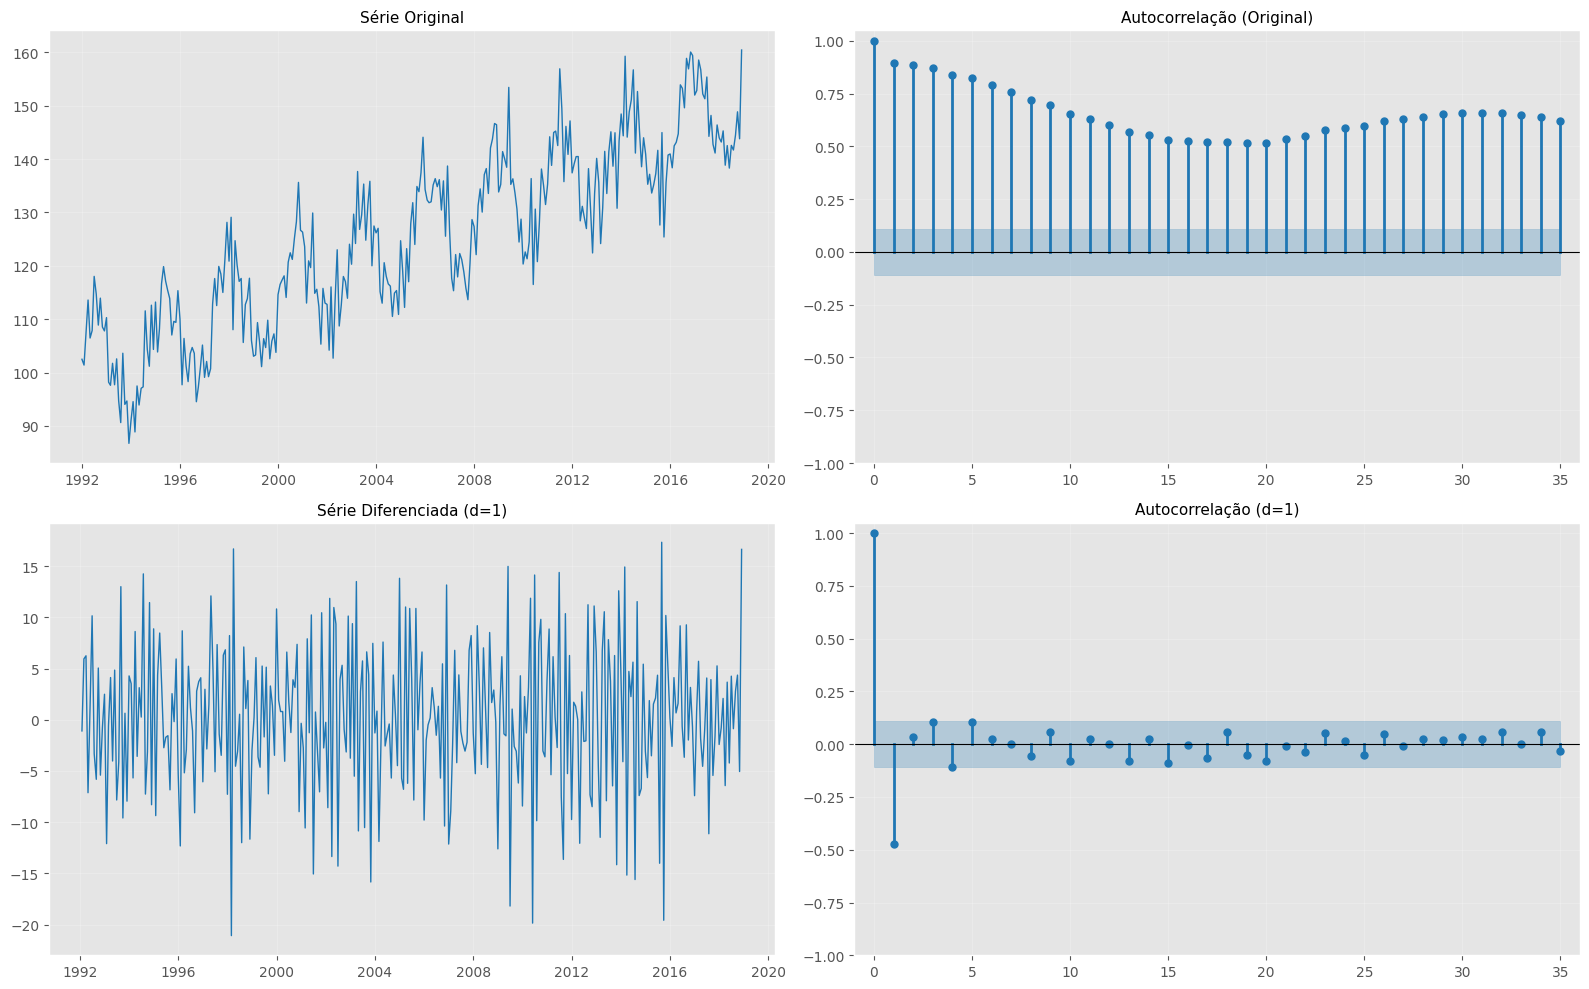

Identificação (d=1): Observe o decaimento para escolher p e q.


In [5]:
# Tenta d=1 (Primeira Diferença)
# Fonte: W_t = Z_t - Z_{t-1} [9]
print("Analisando d=1...")
model.identificacao(d=1)

**Interpretação**: Observe os gráficos gerados acima.

1. Se a FAC de d=1 decai rapidamente para zero, a série diferenciada é estacionária. Logo, fixamos d=1.
2. Olhe para os "picos" que saem do intervalo de confiança.

    * Exemplo teórico: Se a FACP tem corte no lag 1 e a FAC decai, sugere AR(1).
    * Após diferenciar, modelos como ARIMA(1,1,0) ou ARIMA(0,1,1) são candidatos.

## 5. Fase 2: Estimação

Nesta etapa, utilizamos os valores de p,d,q escolhidos para estimar os parâmetros ϕ (auto-regressivos) e θ (médias móveis). A biblioteca utiliza o método de Mínimos Quadrados Condicional (minimizar a soma dos erros quadrados S∗).

Vamos estimar um modelo candidato sugerido pelo texto: ARIMA(1,1,0).

In [6]:
# Escolha baseada na identificação visual ou sugestão do texto [10]
p_escolhido = 1
d_escolhido = 1
q_escolhido = 0

print(f"Estimando modelo ARIMA({p_escolhido},{d_escolhido},{q_escolhido})...")
model.estimacao(p=p_escolhido, q=q_escolhido)

Estimando modelo ARIMA(1,1,0)...

=== ESTIMAÇÃO (Mínimos Quadrados Condicionais) ===
Modelo: ARIMA(1,1,0)
  Parâmetro  Valor Estimado
0     phi_1       -0.479603
Sigma^2 (Variância do Ruído): 40.5613
📄 Resultados salvos: runs/analise_cerveja/02_estimacao.txt


A saída acima mostra os valores estimados para ϕ e a variância do ruído (σ^2). 

O princípio da parcimônia diz que devemos buscar o modelo com menor número de parâmetros que explique bem os dados.

## 6. Fase 3: Diagnóstico

Um modelo é adequado se os resíduos (erros) se comportarem como Ruído Branco: média zero, variância constante e sem correlação.

O método diagnostico calcula a estatística Q de Ljung-Box. Se Q for pequeno (e o gráfico da FAC dos resíduos não tiver picos significativos), o modelo é aceito.

Realizando diagnóstico dos resíduos...

=== DIAGNÓSTICO ===
Estatística Q (Ljung-Box) para 20 lags: 59.3690
Graus de liberdade (K - p - q): 19


/home/gerson/Projects/Personal/boxjenkins/boxjenkins/models.py:402: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


📊 Gráfico salvo: runs/analise_cerveja/plots/03_diagnostico_p1_q0.png


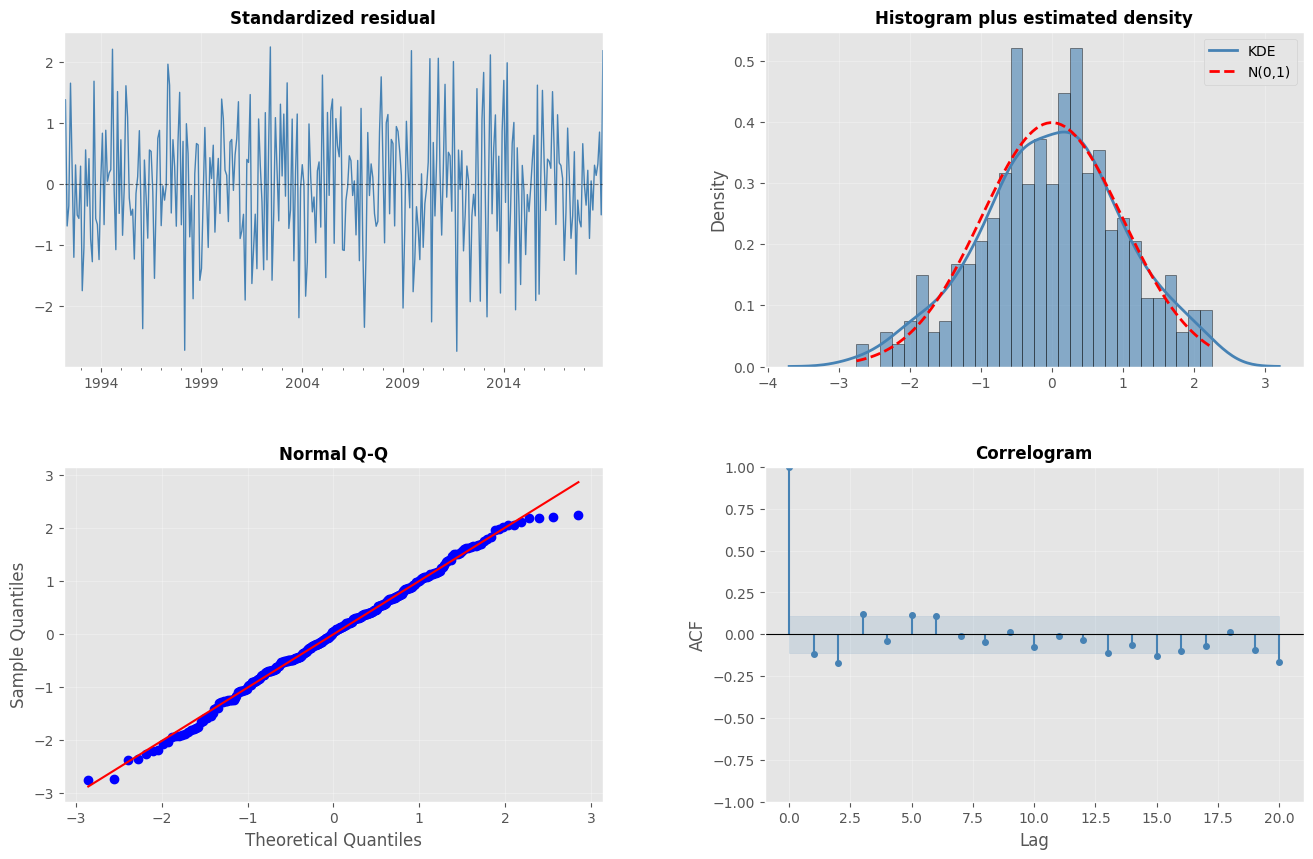

📄 Resultados salvos: runs/analise_cerveja/03_diagnostico.txt


In [7]:
print("Realizando diagnóstico dos resíduos...")
model.diagnostico()

**Análise:**

* Verifique o gráfico da FAC dos resíduos. Se todos os picos estiverem dentro das linhas azuis (intervalo de confiança), os resíduos não têm correlação serial significativa.

* Verifique a estatística Q impressa. Valores altos indicam inadequação.

## 7. Fase 4: Previsão

Com o modelo validado, geramos previsões para o futuro. O cálculo utiliza a equação de diferenças, projetando os valores passo a passo e reintegrando a série (somando as diferenças) para voltar à escala original.

Gerando previsão para 12 passos à frente...
📊 Gráfico salvo: runs/analise_cerveja/plots/04_previsao_12steps.png


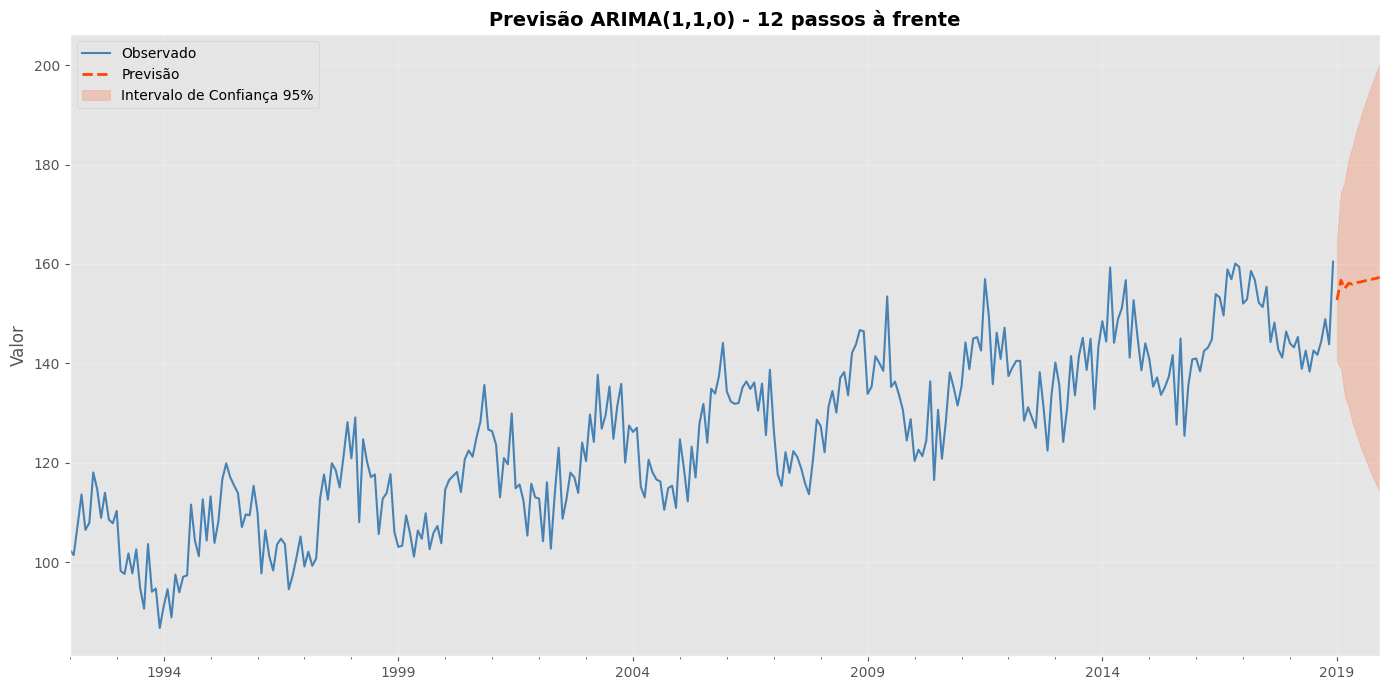


=== PREVISÃO ===
2019-01-01    152.746530
2019-02-01    156.712446
2019-03-01    155.075971
2019-04-01    156.126417
2019-05-01    155.888208
2019-06-01    156.268042
2019-07-01    156.351461
2019-08-01    156.577041
2019-09-01    156.734440
2019-10-01    156.924539
2019-11-01    157.098955
2019-12-01    157.280893
Freq: MS, dtype: float64
📄 Previsões salvas: runs/analise_cerveja/04_previsao.csv
📄 Metadados salvos: runs/analise_cerveja/metadata.json

✅ Execução completa! Resultados em: runs/analise_cerveja

Valores Previstos:
2019-01-01    152.746530
2019-02-01    156.712446
2019-03-01    155.075971
2019-04-01    156.126417
2019-05-01    155.888208
2019-06-01    156.268042
2019-07-01    156.351461
2019-08-01    156.577041
2019-09-01    156.734440
2019-10-01    156.924539
2019-11-01    157.098955
2019-12-01    157.280893
Freq: MS, dtype: float64


In [8]:
# Prever os próximos 12 meses (horizonte de tempo)
steps_ahead = 12
print(f"Gerando previsão para {steps_ahead} passos à frente...")

forecast = model.previsao(steps=steps_ahead)

# Exibir os valores previstos
print("\nValores Previstos:")
print(forecast.tail(steps_ahead))

### Conclusão

O gráfico final apresenta o histórico (em azul) e a previsão (em vermelho tracejado). Se o modelo capturou bem a dinâmica (AR) e a tendência (I), a linha vermelha deve parecer uma continuação natural da série.


>**Nota:** Os resultados e gráficos foram salvos automaticamente na pasta runs/analise_cerveja/.